## Setup

To do next time: figure out statistical significance test for the ensemble sensitivity

In [11]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import xskillscore as xs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
import scipy.stats as stats


# Set default style to dark background because I like it better
plt.style.use("dark_background")


In [4]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def get_mean_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the mean of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Mean variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).mean(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def calc_ens_sens(predictor: xr.DataArray, predictand: xr.DataArray) -> xr.DataArray:
    """
    Calculate the ensemble sensitivity of the predictand to the predictor.

    Parameters:
    predictor (xr.DataArray): DataArray housing the predictor.
    predictand (xr.DataArray): DataArray containing the predictand

    Returns:
    xr.DataArray: The ensemble sensitivity.
    """

    # Calculate the covariance
    covar = (
        (predictor - predictor.mean(dim=("init", "ne")))
        * (predictand - predictand.mean(dim=("init", "ne")))
    ).mean(dim=("init", "ne"))

    # predictor_var = ((predictor - predictor.mean(dim=("init", "ne"))) ** 2).mean(
    #     dim=("init", "ne")
    # )

    predictor_var = predictor.std(dim=("init","ne")) ** 2
    
    # Calculate sensitivity
    sens = covar / predictor_var

    return sens


In [5]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [6]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## 01 to 02 UTC rainfall

In [7]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)


In [7]:
# Find the point closest to Central Park

# Set desired latitude and longitude (Central Park)
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate Euclidean distance and find the nearest indices
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

# Extract the rainfall value
rain12_nyc = rain12.isel(lat=lat_ind, lon=lon_ind)    

## PW

In [8]:
# Get time-average PW
pw = get_field(wofs_all,"pw","2021-09-01 23:00:00", "2021-09-02 01:00:00", init)

In [38]:
corr = xs.pearson_r(pw, rain12_aoi, dim=["ne", "init"]).load()
slope = xs.linslope(pw, rain12_aoi, dim=["ne", "init"]).load()
pval = xs.pearson_r_p_value(pw, rain12_aoi, dim=["ne", "init"]).load()


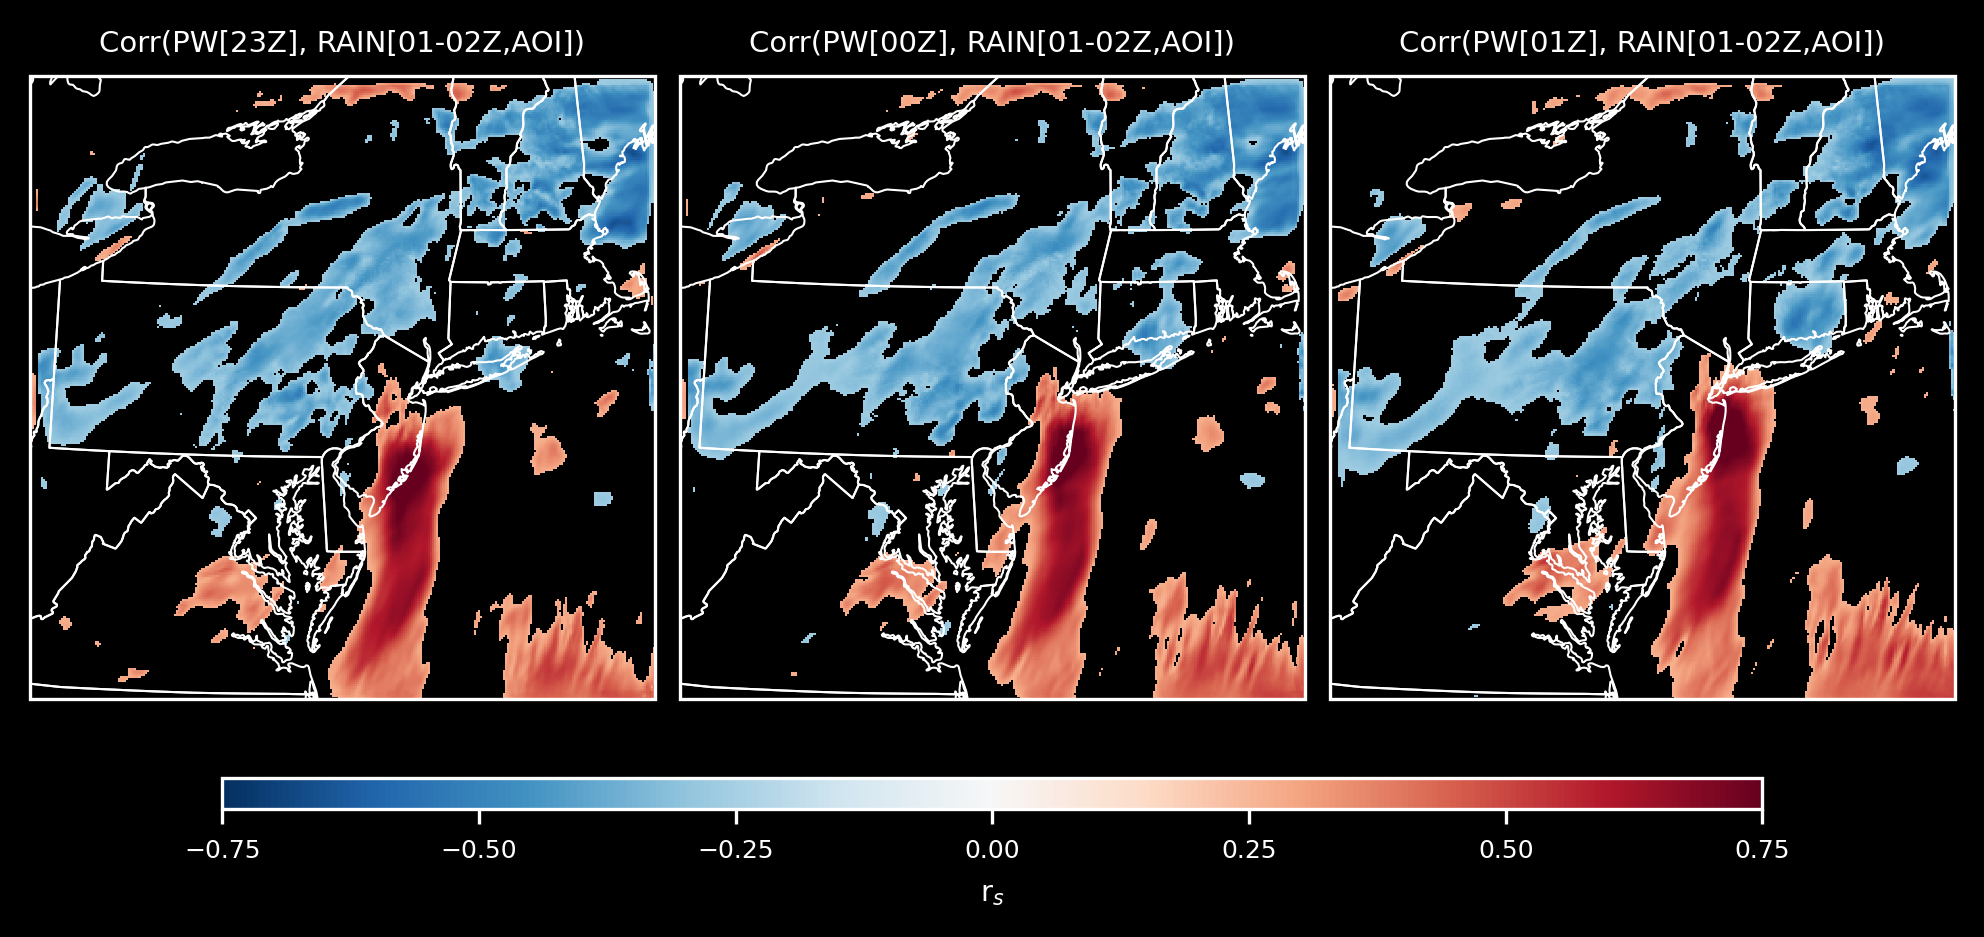

In [40]:
times = ["2021-09-01 23:30:00", "2021-09-02 00:00:00", "2021-09-02 00:30:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(PW[23Z], RAIN[01-02Z,AOI])",
    "Corr(PW[00Z], RAIN[01-02Z,AOI])",
    "Corr(PW[01Z], RAIN[01-02Z,AOI])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i],fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])

plt.show()

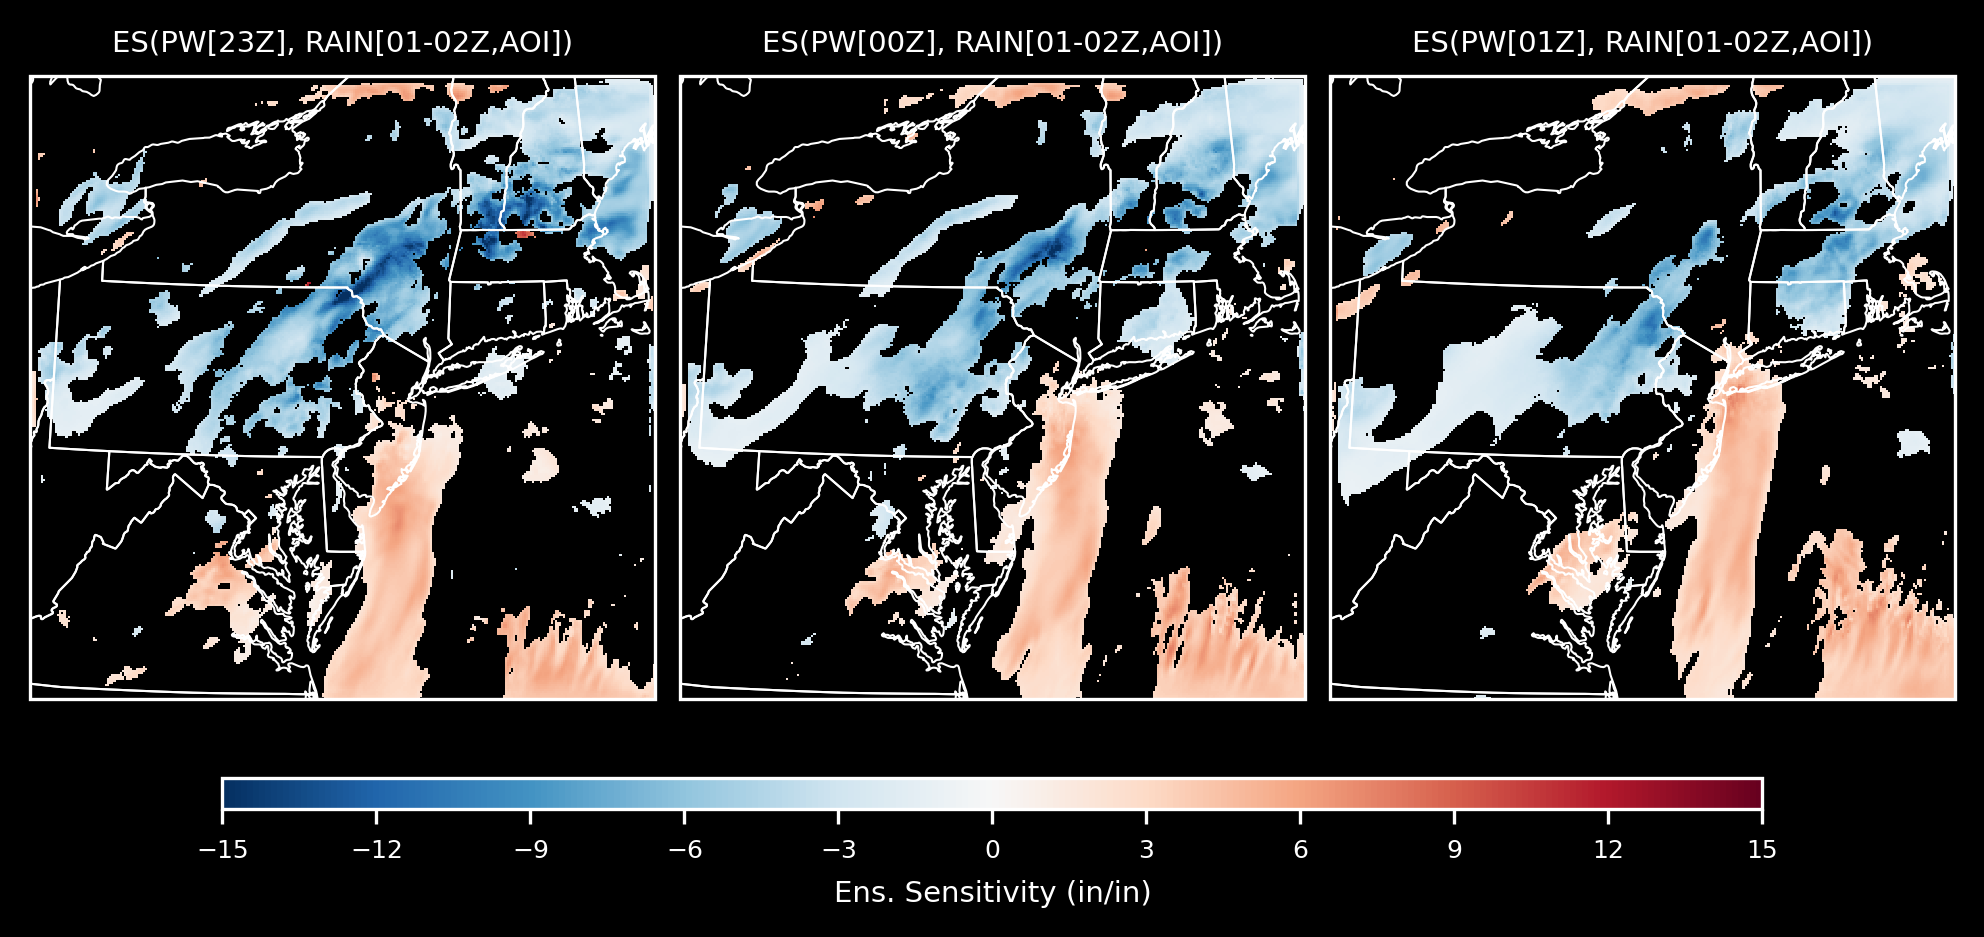

In [25]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [slope.sel(time=t).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "ES(PW[23Z], RAIN[01-02Z,AOI])",
    "ES(PW[00Z], RAIN[01-02Z,AOI])",
    "ES(PW[01Z], RAIN[01-02Z,AOI])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-15,
        vmax=15,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i],fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"Ens. Sensitivity (in/in)", fontsize=7)
cb.set_ticks(range(-15,16,3))

plt.show()

In [24]:
wofs_all[0].rain.units

'in.'

## 850 mb winds

In [35]:
# Get time-averaged V850
v850 = get_field(
    wofs_all, "V_850", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
)
# Get time-averaged u850
u850 = get_field(
    wofs_all, "U_850", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
)


### V850

In [36]:
corr = xs.spearman_r(v850, rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(v850, rain12_nyc, dim=["ne", "init"]).load()

/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xskillscore/core/np_deterministic.py:314: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


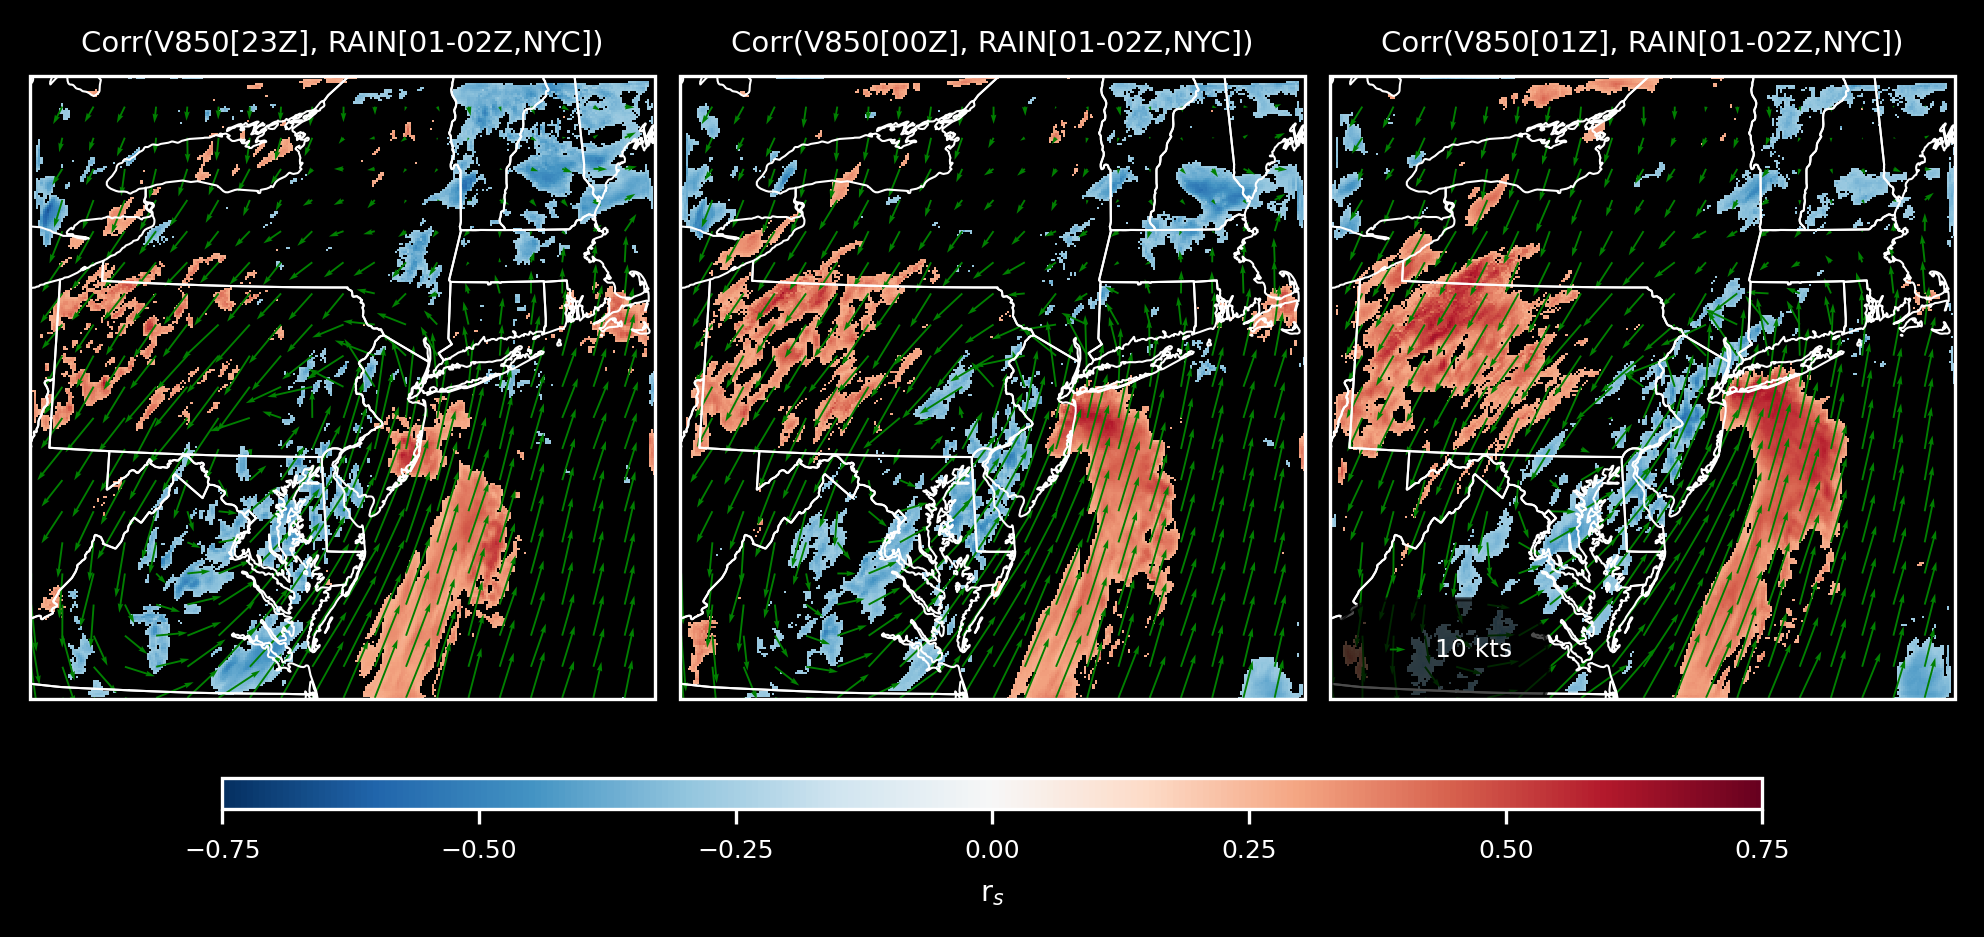

In [47]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
uwinds = [u850.sel(time=t).mean(dim=("ne","init")).squeeze() for t in times]
vwinds = [v850.sel(time=t).mean(dim=("ne","init")).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(V850[23Z], RAIN[01-02Z,NYC])",
    "Corr(V850[00Z], RAIN[01-02Z,NYC])",
    "Corr(V850[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Take every 15th lat and lon values
lon_quiv = lon.values[::15, ::15]
lat_quiv = lat.values[::15, ::15]
scale = 400

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        uwinds[i].values[::15, ::15],
        vwinds[i].values[::15, ::15],
        transform=ccrs.PlateCarree(),
        scale=scale,
        color="green",
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Add a reference vector with a background rectangle
bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                boxstyle="round,pad=0.1",
                                transform=ax.transAxes,
                                color='black',
                                alpha=0.7,
                                zorder=2)
ax.add_patch(bbox)
qk = ax.quiverkey(q, 0.12, 0.08, 10, '10 kts', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='green')
qk.set_zorder(3)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()


### U850

In [48]:
corr = xs.spearman_r(u850, rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(u850, rain12_nyc, dim=["ne", "init"]).load()

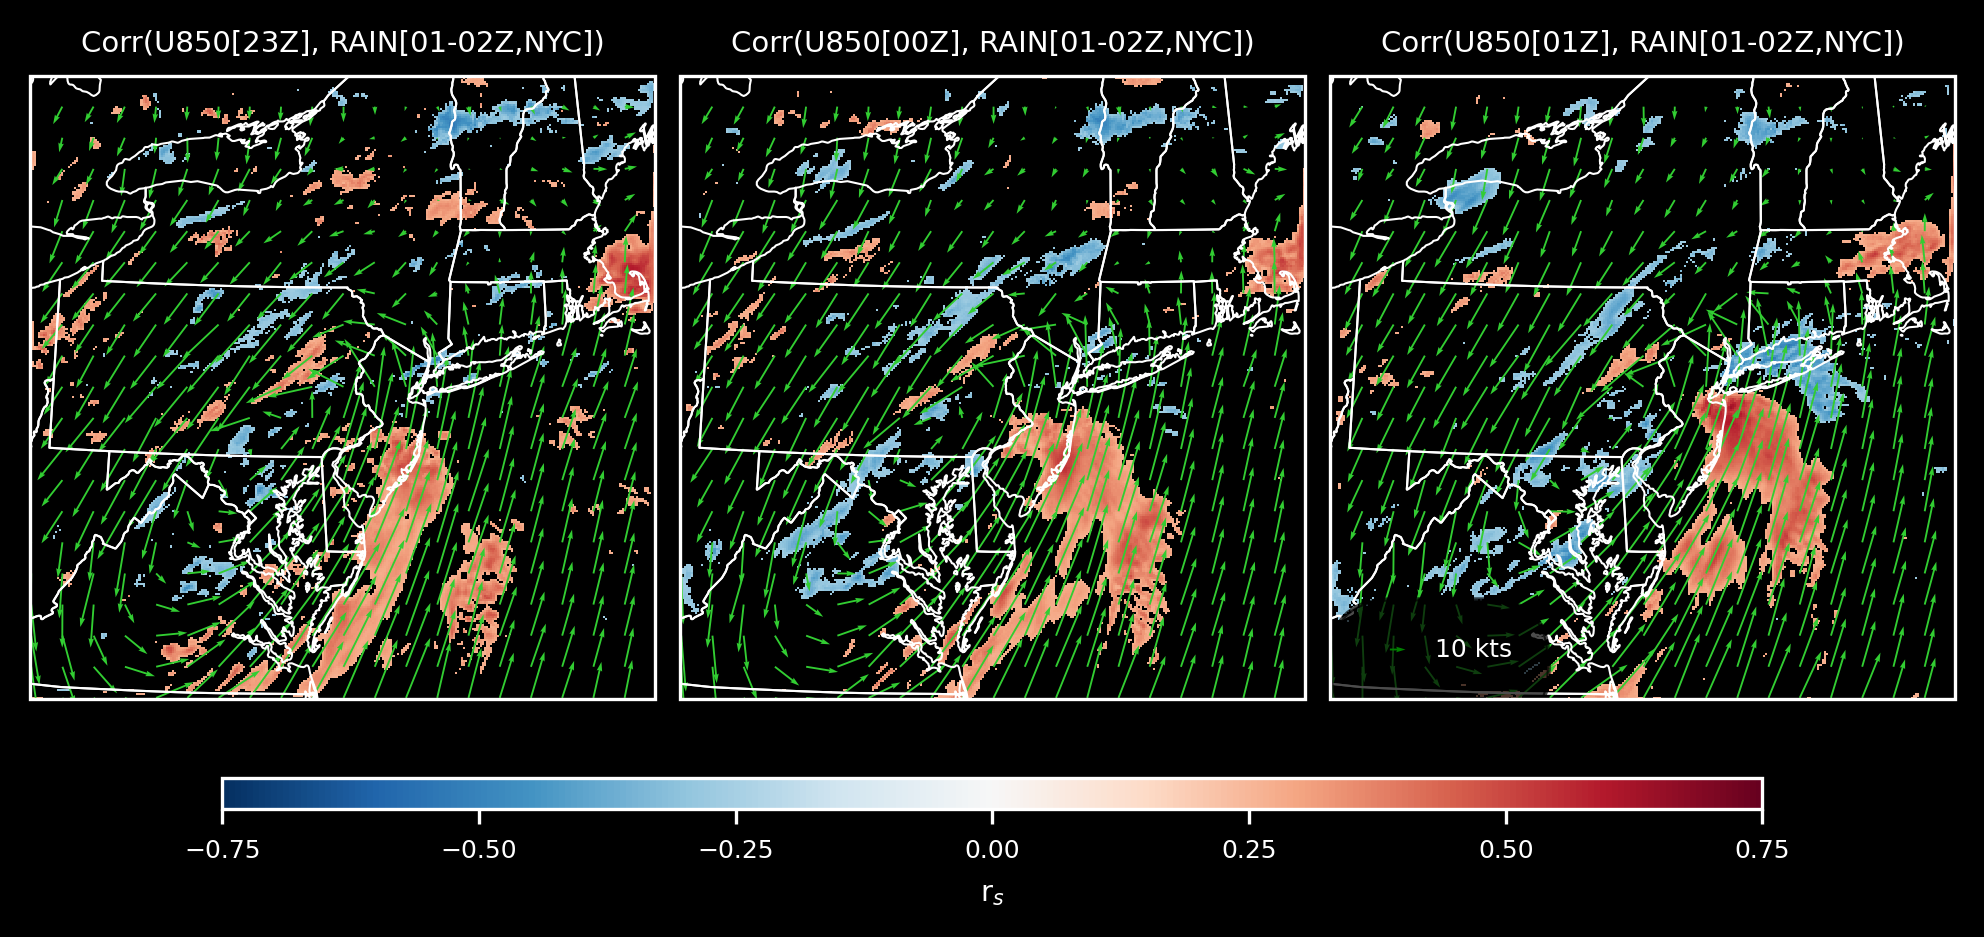

In [54]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
uwinds = [u850.sel(time=t).mean(dim=("ne","init")).squeeze() for t in times]
vwinds = [v850.sel(time=t).mean(dim=("ne","init")).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(U850[23Z], RAIN[01-02Z,NYC])",
    "Corr(U850[00Z], RAIN[01-02Z,NYC])",
    "Corr(U850[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Take every 15th lat and lon values
lon_quiv = lon.values[::15, ::15]
lat_quiv = lat.values[::15, ::15]
scale = 400

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        uwinds[i].values[::15, ::15],
        vwinds[i].values[::15, ::15],
        transform=ccrs.PlateCarree(),
        scale=scale,
        color="limegreen",
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Add a reference vector with a background rectangle
bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                boxstyle="round,pad=0.1",
                                transform=ax.transAxes,
                                color='black',
                                alpha=0.7,
                                zorder=2)
ax.add_patch(bbox)
qk = ax.quiverkey(q, 0.12, 0.08, 10, '10 kts', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='green')
qk.set_zorder(3)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()


### Convergence

In [85]:
# Get time-averaged V850
v850 = smooth(
    get_field(
        wofs_all, "V_850", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
    ).rename({"lon": "x", "lat": "y"}),
    axes=(-2, -1),sigma=5
)/1.94384
v850["x"] = v850.x * 3000
v850["y"] = v850.y * 3000
# Get time-averaged u850
u850 = smooth(
    get_field(
        wofs_all, "U_850", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
    ).rename({"lon": "x", "lat": "y"}),
    axes=(-2, -1),sigma=5
)/1.94384
u850["x"] = u850.x * 3000
u850["y"] = u850.y * 3000

# calculate convergence
conv850 = -(u850.differentiate("x") + v850.differentiate("y"))


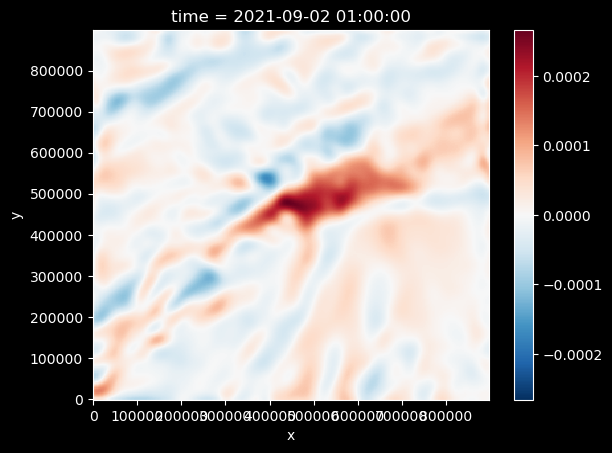

In [98]:
conv850.sel(time="2021-09-02 01:00:00").mean(dim=["ne","init"]).plot()

In [96]:
corr = xs.spearman_r(conv850.sel(time="2021-09-02 01:00:00"), rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(conv850.sel(time="2021-09-02 01:00:00"), rain12_nyc, dim=["ne", "init"]).load()

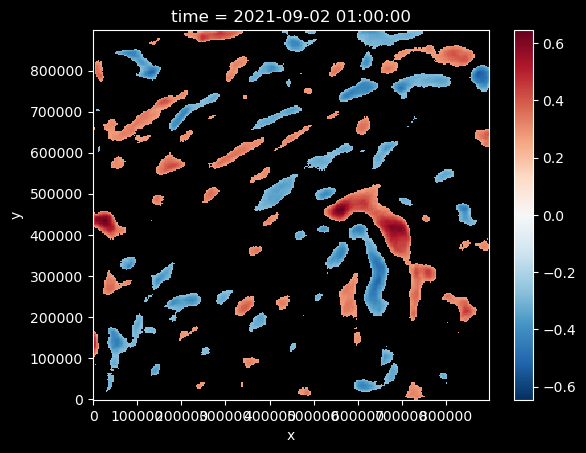

In [95]:
corr.where(np.abs(pval) < 0.025).sel(time="2021-09-02 01:00:00").squeeze().plot()

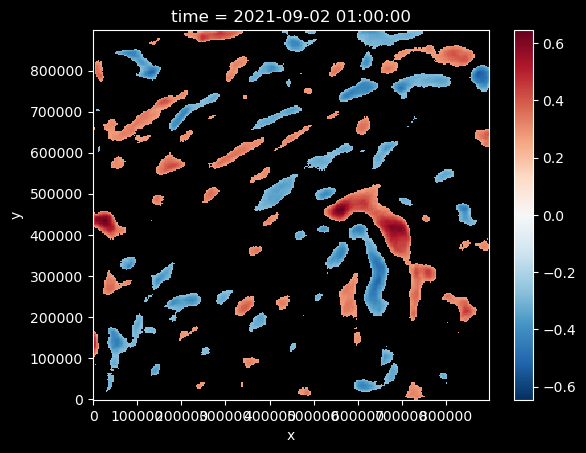

In [97]:
corr.where(np.abs(pval) < 0.025).squeeze().plot()

## CAPE

In [56]:
# Get time-averaged CAPE
cape = get_field(
    wofs_all, "cape_ml", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
)

In [57]:
corr = xs.spearman_r(cape, rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(cape, rain12_nyc, dim=["ne", "init"]).load()

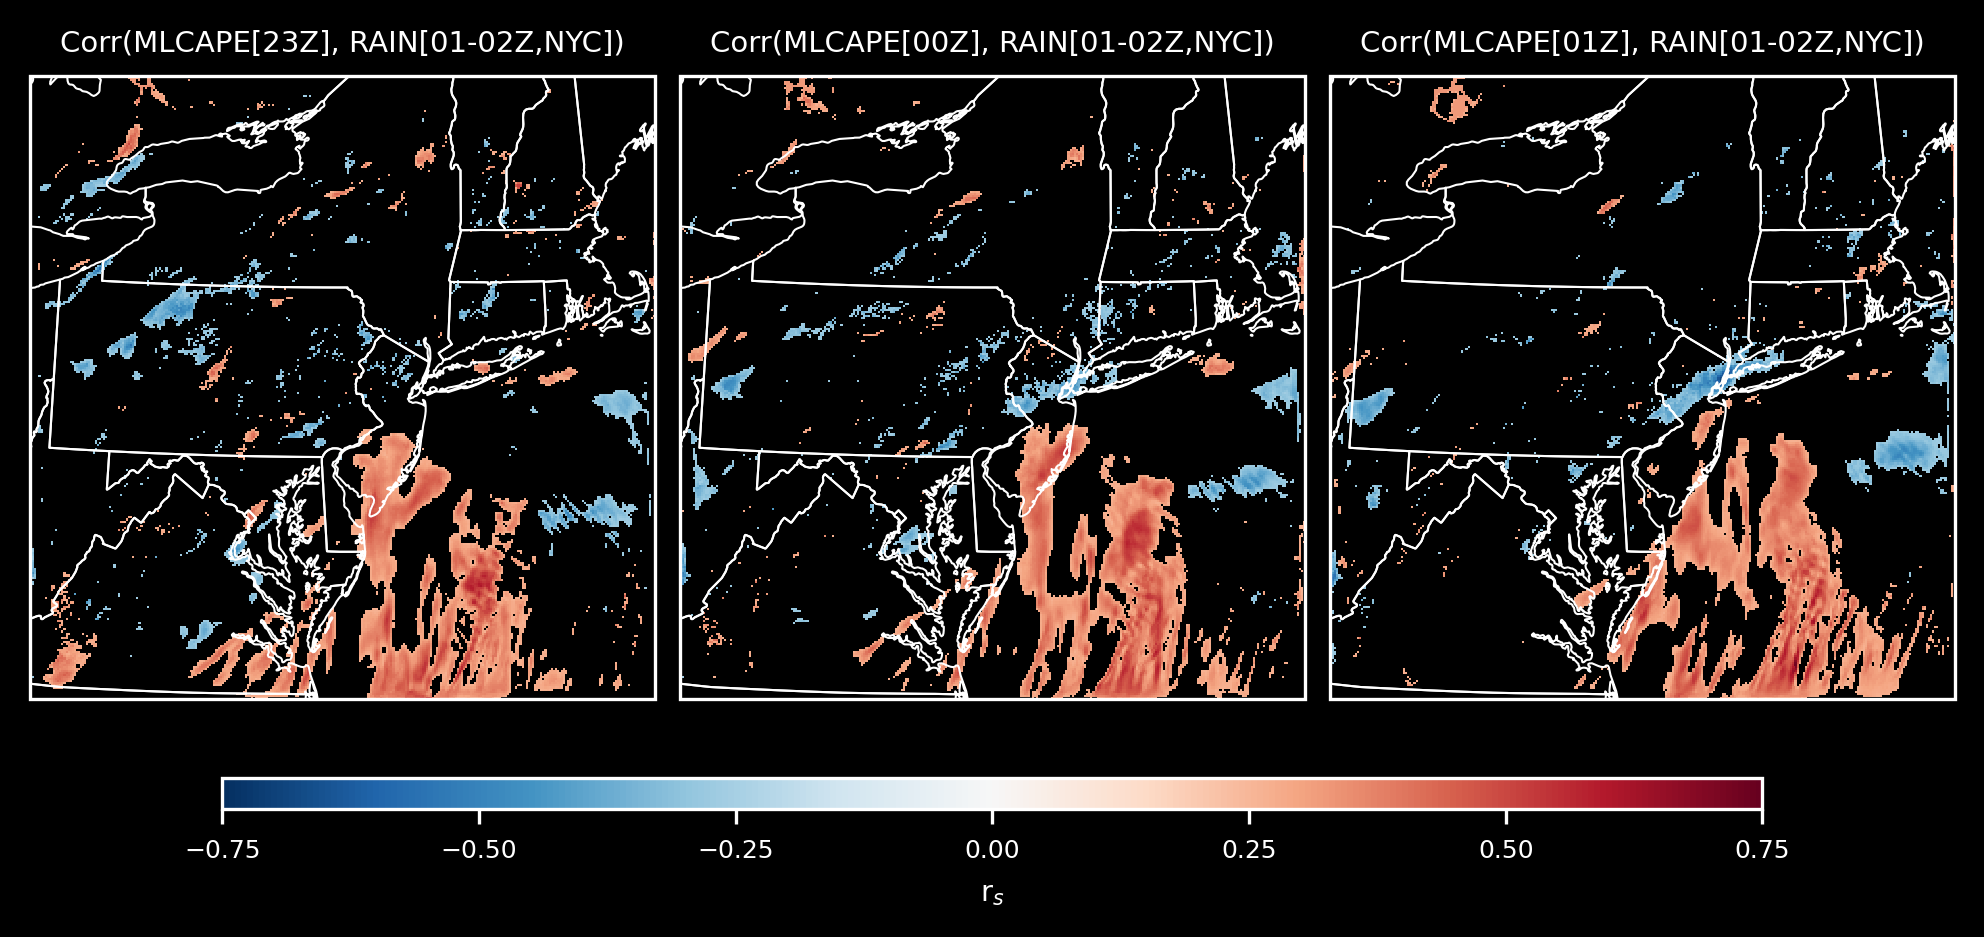

In [58]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(MLCAPE[23Z], RAIN[01-02Z,NYC])",
    "Corr(MLCAPE[00Z], RAIN[01-02Z,NYC])",
    "Corr(MLCAPE[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75,0.76,0.25))  # type: ignore

plt.show()

## Z500

In [20]:
# Get time-averaged Z500
z500 = smooth(get_field(
    wofs_all, "geo_hgt_500", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
),axes=(-1,-2))

In [21]:
corr = xs.spearman_r(z500, rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(z500, rain12_nyc, dim=["ne", "init"]).load()

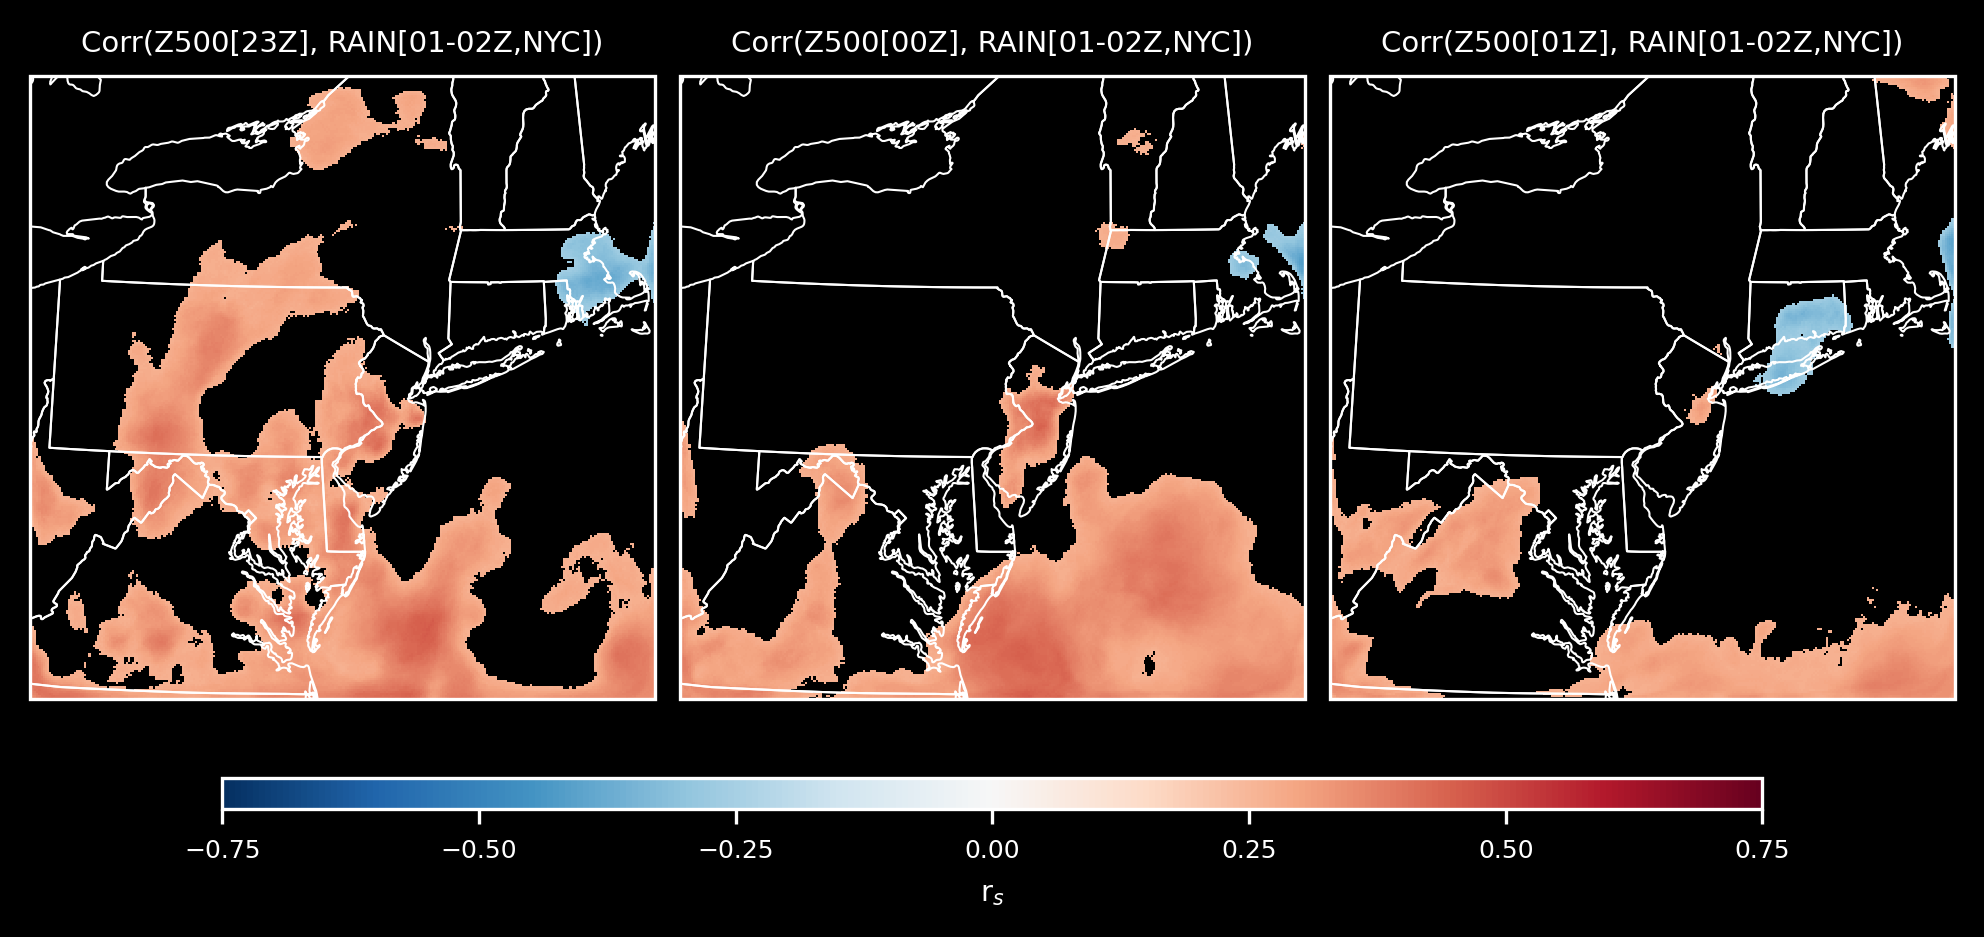

In [25]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(Z500[23Z], RAIN[01-02Z,NYC])",
    "Corr(Z500[00Z], RAIN[01-02Z,NYC])",
    "Corr(Z500[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()


## Z850

In [26]:
# Get time-averaged Z850
z850 = smooth(get_field(
    wofs_all, "geo_hgt_850", "2021-09-01 23:00:00", "2021-09-02 01:00:00", init
),axes=(-1,-2))

In [27]:
corr = xs.spearman_r(z850, rain12_nyc, dim=["ne", "init"]).load()
pval = xs.spearman_r_p_value(z850, rain12_nyc, dim=["ne", "init"]).load()

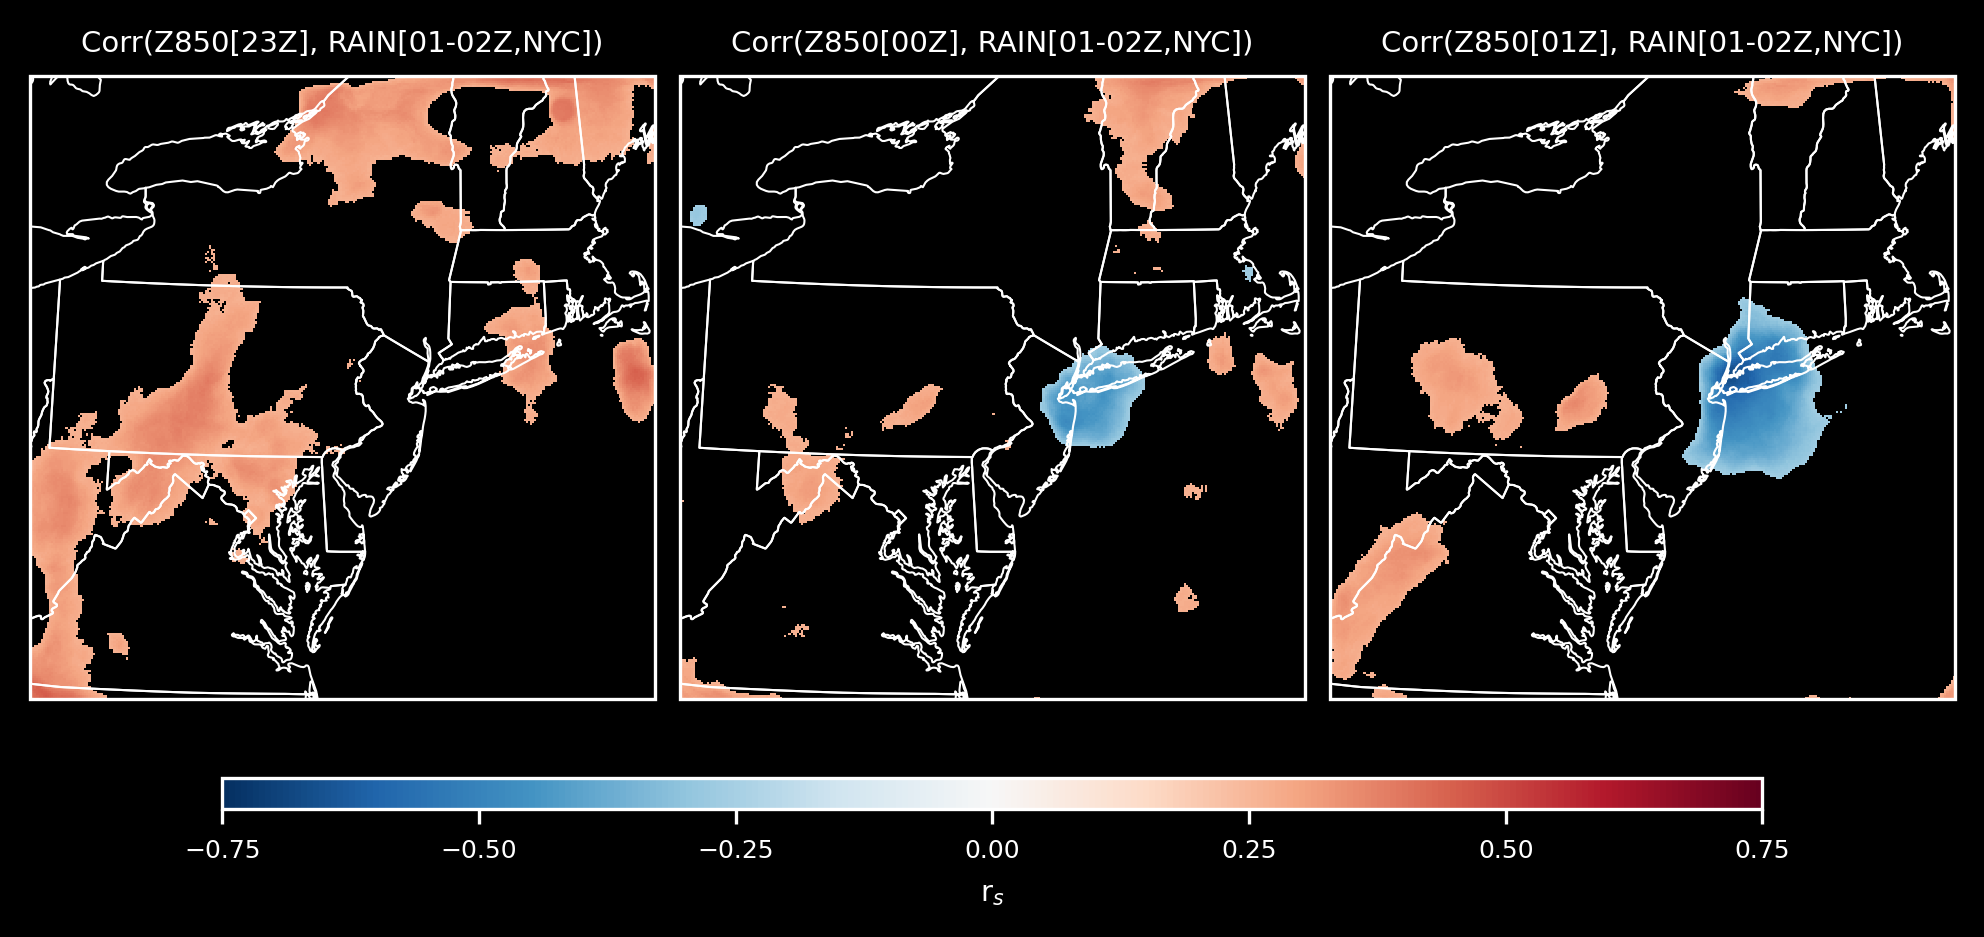

In [28]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
# Get data to plot
data = [corr.sel(time=t).squeeze() for t in times]
pdata = [pval.sel(time=t).squeeze() for t in times]
titles = [
    "Corr(Z850[23Z], RAIN[01-02Z,NYC])",
    "Corr(Z850[00Z], RAIN[01-02Z,NYC])",
    "Corr(Z850[01Z], RAIN[01-02Z,NYC])",
]

# Make figure
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(6.5, 3),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
for i, ax in enumerate(axes):  # type: ignore
    pc = ax.pcolormesh(
        lon,
        lat,
        data[i].where(abs(pdata[i]) < 0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.75,
        vmax=0.75,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

    ax.set_title(titles[i], fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()


## Preceding rainfall

In [61]:
# Get time-averaged rain
rain_231 = get_total_field(
    wofs_all, "rain", "2021-09-01 23:05:00", "2021-09-02 01:00:00", init
)

In [62]:
corr_231 = xs.spearman_r(rain_231, rain12_nyc, dim=["ne", "init"]).load()
pval_231 = xs.spearman_r_p_value(rain_231, rain12_nyc, dim=["ne", "init"]).load()

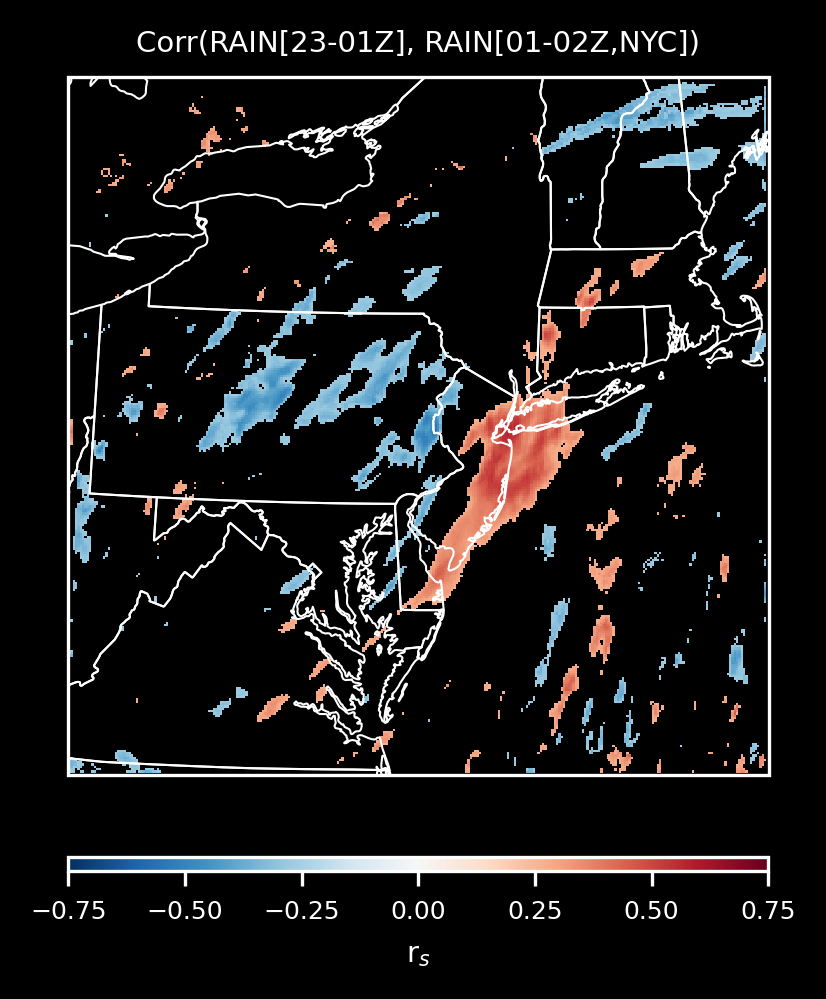

In [65]:
# Get data to plot
data = corr_231
pdata = pval_231
titles = "Corr(RAIN[23-01Z], RAIN[01-02Z,NYC])"

# Make figure
fig, ax = plt.subplots(
    1,
    1,
    figsize=(
        3,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
pc = ax.pcolormesh(
    lon,
    lat,
    data.where(np.fabs(pdata) < 0.025),
    cmap="RdBu_r",
    zorder=1,
    transform=ccrs.PlateCarree(),
    vmin=-0.75,
    vmax=0.75,
)

ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

ax.set_title(titles, fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=ax,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()

## Concurrent rainfall

In [27]:
# No need to calculate the 1-2Z rainfall because we already have it
corr_12 = xs.spearman_r(rain12, rain12_nyc, dim=["ne", "init"]).load().fillna(0)
pval_12 = xs.spearman_r_p_value(rain12, rain12_nyc, dim=["ne", "init"]).load()

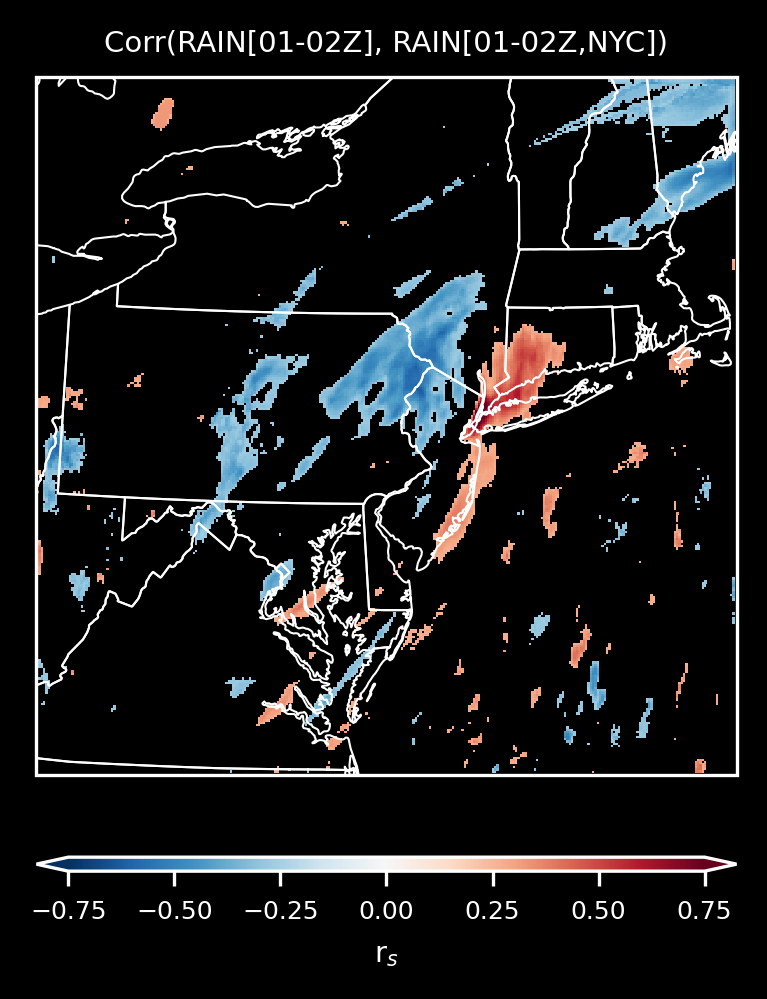

In [29]:
# Get data to plot
data = corr_12
pdata = pval_12
titles = "Corr(RAIN[01-02Z], RAIN[01-02Z,NYC])"

# Make figure
fig, ax = plt.subplots(
    1,
    1,
    figsize=(
        3,
        3.2,
    ),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Plot spatial correlation
pc = ax.pcolormesh(
    lon,
    lat,
    data.where(np.fabs(pdata) < 0.025),
    cmap="RdBu_r",
    zorder=1,
    transform=ccrs.PlateCarree(),
    vmin=-0.75,
    vmax=0.75,
)

ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white", zorder=2)

ax.set_title(titles, fontsize=7)

# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=ax,
    orientation="horizontal",
    pad=0.1,
    aspect=50,
    shrink=0.8,
    extend="both"
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"r$_s$", fontsize=7)
cb.set_ticks(np.arange(-0.75, 0.76, 0.25))  # type: ignore

plt.show()